##  Ingatlanfenntartási Bírságok Megértése és Előrejelzése

#### Feladat:
   - a megkapott adatok alapján egy adatmodell készítés, melynek előre kell jelezni, hogy egy adott rendbontási bírságot időben kifizetnek-e

#### Értékelés:
  - mekkora a valószínűsége annak, hogy az adott rendbontási bírságot időben kifizetik
  - értékelési metrica: AUC

#### Feladat megvalósítása:

  - Machine learning pipline:  

1. Importok, adatbetöltés + Merge

2. EDA
  - Hiányzó értékek
  - Leakege és irreleváns oszlopok törlése

3. Feature engineering

  - Traget létrehozása + szűrés
  - Dátumok konvertálása
  - Log transzormált pénzösszegek
  - Cím és koordináta ellenőrzés
  - Fature lista összeállítás 

4. Preprocessing pipeline

 - numerikus input, kategóriák kódolása

5. Vizualizációk

  - korrelációs mátrix
  - compliance eloszlás
  - violation code gyakoriság
  - PCA

6. Modellek építése

  - Logistic Regression
  - Random Forest
  - Gradient Boost Classifier

7. Értékelés
  - ROC AUC, PR AUC, precisions, recall, F1  

8. Következtetés

#### A feladathoz kapott fájlok:

  - train.csv
  - address.csv
  - latlons.csv

<div style="page-break before: always;"></div>

###  1. Importok, adatbetöltés + Merge

In [1]:

import numpy as np   
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

In [2]:
addresses = pd.read_csv(
    "/Users/User/Desktop/PYTHONPRO/DATA_SCIENCE_KURZUS_4_blokk/notebooks/project_hazi/addresses.csv")
addresses.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [3]:
latlons = pd.read_csv(
    "/Users/User/Desktop/PYTHONPRO/DATA_SCIENCE_KURZUS_4_blokk/notebooks/project_hazi/latlons.csv")
latlons.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [4]:
train = pd.read_csv(
    "/Users/User/Desktop/PYTHONPRO/DATA_SCIENCE_KURZUS_4_blokk/notebooks/project_hazi/train.csv")

C:\Users\User\AppData\Local\Temp\ipykernel_36392\3855574826.py:1: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(


<div style="page-brak-before: always;"></div>

<div style="page-brak-before: always;"></div>

In [5]:
#========================================================================
# train.csv file vilation_street_number átalakítása eredeti 2900.0 -> új 2900
#========================================================================

train['violation_street_number'] = (
    train['violation_street_number'] 
    .astype(str)
    .apply(lambda x: str(int(float(x))) if x.replace('.', '').isdigit() else "")
)
train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [6]:
#========================================================================
# train.csv file vilation_street_name kisbetűssé alakítása és összefűzése
#========================================================================

train['violation_street_name'] = train['violation_street_name'].str.lower().str.strip()

train['address'] = (
    train['violation_street_number'].astype(str) + ' ' +
    train['violation_street_name'].astype(str) + ', Detroit MI'
)

train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,tyler,NaN,3.0,S. WICKER,CHICAGO,...,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI"
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,central,NaN,2959.0,Martin Luther King,Detroit,...,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI"
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,longfellow,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI"
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,longfellow,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI"
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,churchill,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI"


In [7]:
#========================================================================
# train.csv és latlons.csv összefűzése
#========================================================================

df = train.merge(latlons, on='address', how='left')
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,tyler,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,central,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,longfellow,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,longfellow,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,churchill,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


##### 1. rész Összefoglaló: Importok, adatbetöltés + Merge  

A három adatforrás összeillesztését a ticket_id és az address mezők alapján végeztem el.

A violation_street_number oszlop tisztítására azért volt szükség, mert a forrásban 

lebegőpontos formátumban (pl. 2900.0) szerepelt, amit egységesen számmá konvertáltam.

================================================================================================================================

#### 2. EDA + hiányzó értékek

In [11]:
df.isnull().sum()

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
b

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  object 
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [9]:
#========================================================================
# Jellemzők Nan értékének összegzése
#========================================================================

df.isna().sum().sort_values(ascending=False) 

violation_zip_code            250306
grafitti_status               250305
non_us_str_code               250303
collection_status             213409
payment_date                  209193
compliance                     90426
hearing_date                   12491
mailing_address_str_number      3602
state                             93
violator_name                     34
mailing_address_str_name           4
lon                                3
lat                                3
fine_amount                        1
zip_code                           1
agency_name                        0
ticket_id                          0
violation_street_number            0
inspector_name                     0
city                               0
violation_street_name              0
admin_fee                          0
disposition                        0
violation_description              0
violation_code                     0
country                            0
ticket_issued_date                 0
d

=====================================================================================================================

-------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Megjegyzés - jelenlegi helyzet áttekintése:

Előnyök:
 - dátum oszlopok beazonosítva vannak, később kezeljük őket
 - van lat/lon -> ez jó predict feature (pl. ebben a körzetben 30% a késedelmi ráta)
 - főbb jellemzők megvannak 
 - (250306, 37) van rendesen adat a modellek tanításához

Hátrányok (javítandó):
 - több oszlop erősen hiányos vagy teljesen irreleváns (violation_zip_code, grafitti_status
    non_us_str_code, collection_status)
 - leakage gyanús jellemzők találhatóak (payment_date, compliance_detail, payment_status)
 - a kategóriás szöveges mezők erősen szétaprózottak 
 - hiányzó hearing_date értékek -> kezelni szükséges
 - van pár NaN lat/lon
 - a state, mailing_address, zip_code eléggé zajos

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

===============================================================================================================================

In [10]:
#========================================================================
# Leakage és irreleváns oszlopok (jellemzők) eldobása
#========================================================================

leak_cols = [
    'payment_date',
    'payment_amount',
    'payment_status',      
    'balance_due',
    'compliance_detail'  
]

df = df.drop(columns=leak_cols, errors='ignore')

drop_cols = [
    'violation_zip_code',
    'grafitti_status',
    'non_us_str_code',      
    'collection_status'  
]

df = df.drop(columns=drop_cols)
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,...,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,tyler,3.0,S. WICKER,CHICAGO,IL,...,20.0,10.0,25.0,0.0,0.0,305.0,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,central,2959.0,Martin Luther King,Detroit,MI,...,20.0,10.0,75.0,0.0,0.0,855.0,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,longfellow,23658.0,P.O. BOX,DETROIT,MI,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,longfellow,5.0,ST. CLAIR,DETROIT,MI,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,churchill,7449.0,CHURCHILL,DETROIT,MI,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


In [11]:
df.isnull().sum()

ticket_id                         0
agency_name                       0
inspector_name                    0
violator_name                    34
violation_street_number           0
violation_street_name             0
mailing_address_str_number     3602
mailing_address_str_name          4
city                              0
state                            93
zip_code                          1
country                           0
ticket_issued_date                0
hearing_date                  12491
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       1
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
compliance                    90426
address                           0
lat                               3
lon                         

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  object 
 5   violation_street_name       250306 non-null  object 
 6   mailing_address_str_number  246704 non-null  float64
 7   mailing_address_str_name    250302 non-null  object 
 8   city                        250306 non-null  object 
 9   state                       250213 non-null  object 
 10  zip_code                    250305 non-null  object 
 11  country                     250306 non-null  object 
 12  ticket_issued_date          250306 non-null  object 
 13  hearing_date  

##### 2. rész Összefoglaló: EDA + hiányzó értékek

Az EDA során megállapítottam, hogy több oszlop ('violation_zip_code', 'grafitti_status',

'non_us_str_code', 'collection_status') extrém mértékban hiányos, így a modellbe nem

vonható be. Ezeket eldobtam, mivel sem prediktív, sem használható információtartalmuk nincs.


================================================================================================================================

<div style="page-break-before: always;"></div>


###  3. Feature enigineering

In [13]:
#========================================================================
# Target létrhozása és szűrés
#========================================================================


df = df[df['compliance'].isin([0,1])].copy()
df['target'] = df['compliance']
df.drop(columns=['compliance'], inplace=True)

In [14]:
#========================================================================
# Dátumok konvertálása
#========================================================================


df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'])
df['hearing_date'] = pd.to_datetime(df['hearing_date'], errors='coerce')

df['days_until_hearing'] = (
    df['hearing_date'] - df['ticket_issued_date']
).dt.days.fillna(-1)

df['issue_year'] = df['ticket_issued_date'].dt.year
df['issue_month'] = df['ticket_issued_date'].dt.month
df['issue_dow'] = df['ticket_issued_date'].dt.dayofweek

In [15]:
#========================================================================
# Log-transzformált pénzösszegek 
#========================================================================

money_cols = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount']
for c in money_cols:
    if c in df.columns:
        df[f"log_{c}"] = np.log1p(df[c].fillna(0))

In [16]:
#========================================================================
# Cím / geo feature engineering
#========================================================================

# lat (latitude) oszlop ellenőrzése, ha van koordináta ->1 különben ->0
df['has_latlon'] = df['lat'].notna().astype(int)

# megszámolja és mellé írja, hogy hányszor szerepel az adott cím
df['prior_tickets_by_address'] = df.groupby( 
    ['violation_street_name', 'violation_street_number']   
)['ticket_id'].transform('count')

# megszámolja és mellé írja, hogy hányszor szerepel a bírságot (violator_name)
# kapott cég vagy személy
df['prior_tickets_by_violator'] = df.groupby(
    'violator_name'
)['ticket_id'].transform('count')

In [17]:
#========================================================================
# Feature lista összeállítás
#========================================================================

numeric_feats = [
    'days_until_hearing', 'prior_tickets_by_address',
    'prior_tickets_by_violator', 'has_latlon'
] + [f"log_{c}" for c in money_cols if f"log_{c}" in df.columns]

cat_feats = [
    'violation_code', 'violation_description',
    'disposition', 'agency_name', 'city', 'state'
]

##### 3. rész Összefoglaló: Feature Engineering

A feature engineering során a célváltozót (target) a compliance oszlopból hoztam létre.

Mivel a compliance mező többféle értéket tartalmazhatott (NaN, -1, 0, 1), a modell tanításához

csak a 0 és 1 értékeket tartottam meg, majd ezeket a target oszlopba másoltam.

A hearing_date hiányzó értékeinek kezelése is itt történik, mivel a hearing és a ticket_issued_date

közötti különbség fontos prediktív információ (több idő -> nagyobb eséllyel fizet). A hiányzó

hearing_date esetén -1 napot állítottam be, így külön jelölve a hiányt.

A pénzbeli oszlopokon log-transzformációt alkalmaztam, ami csökkenti a kiugró értékek hatását 

és stabilabb döntésfelületet ad a modelleknek.

A prior_tickets_by_address és proior_tickets_by_violator jellemzők a visszatérő bírságolási

mintázatot ragadják meg. A korábbi szabálysértések száma erős indikátor arra, hogy a tulajdonos 

később hogyan fizet. 

A has_latlon változó azt jelzi, hogy sikerült-e földrajzi koodinátát társítani az adott címhez.

Ez azért hasznos, mert a compliance erősen területfüggő.

A feature engineering eredményeként olyan jellemzőhalmazt kaptam, amely egyensúlyban tartja a 

numerikus, időbeli, földrajzi és viselkedésalapú információkat. 

===========================================================================================================================================================

<div style="page-break-before: always;"></div>

### 4. Preprocessing pipeline

In [18]:
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, cat_feats)
])

##### 4. rész Összefoglaló: Preprocessing pipeline

A preprocessing pipeline két részre oszlik: numerikus és kategóriás jellemzők kezelésére.

A numerikus oszlopoknál median imputációt alkalmaztam, amely robosztus a szélsőértékekkel

szemben, majd StandardScalerrel skáláztam őket a modellek stabilitása érdekében.

A kategóriás jellemzők esetén a leggyakoribb érték szerinti imputálást és OneHotEncodinget

használtam. A handle_unknown="ignore" opció biztosítja, hogy a tesztadatokban megjelenő új

katagóriák miatt, ne hibázzon a modell.

A ColumnTransformer-rel összeállított pipeline garantálja, hogy minden modell ugyanazt az egységes

adat-előkészítést kapja.

============================================================================================================================================================

<div style="page-break-before: always;"></div>

### 5. Vizualizációk

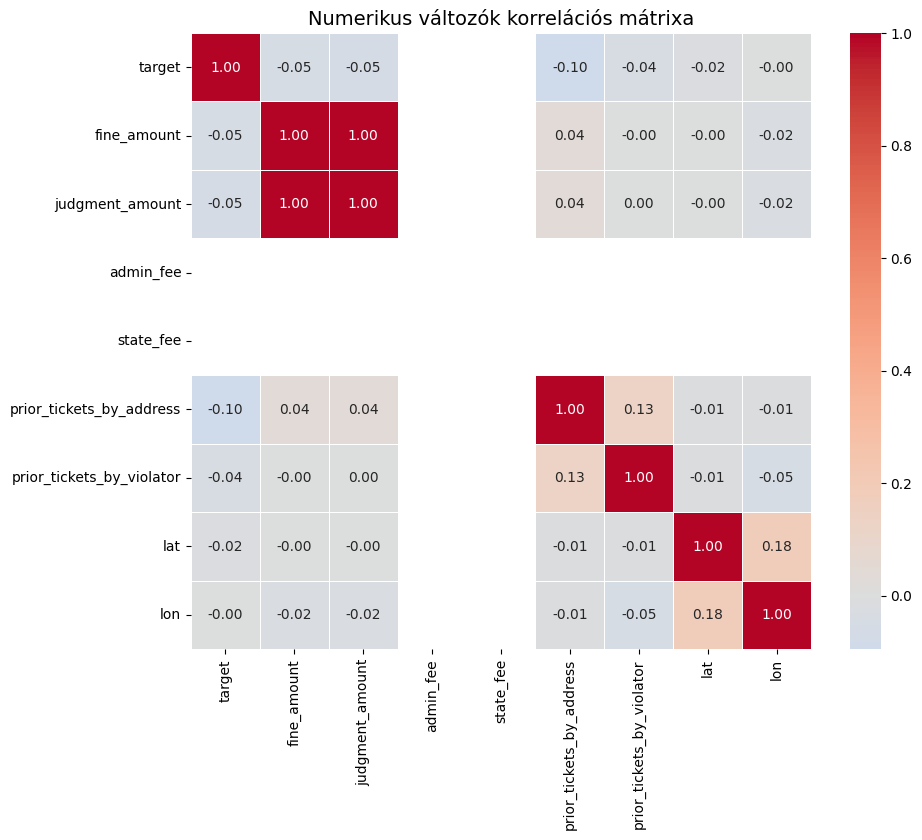

In [19]:
#========================================================================
# Korrelációs mátrix
#========================================================================

import seaborn as sns 

num_for_corr = [
    'target',
    'fine_amount',
    'judgment_amount',
    'admin_fee',
    'state_fee',
    'prior_tickets_by_address',
    'prior_tickets_by_violator',
    'lat',
    'lon'
]

corr = df[num_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Numerikus változók korrelációs mátrixa', fontsize=14)
plt.show()

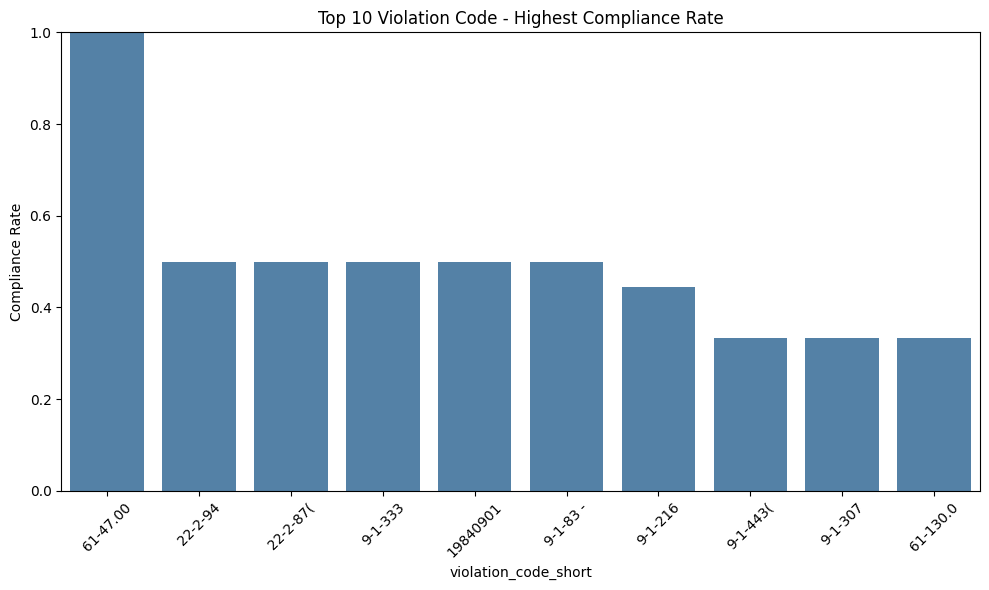

In [20]:
#========================================================================
# Pivot tábla
#  - violation_code TOP10
#  - compliance_rate átlaggal
#========================================================================
vc_compliance = (
        df.groupby('violation_code')['target']
        .mean()
        .reset_index(name='compliance_rate')
        .sort_values(by= 'compliance_rate', ascending=False)
)

data = vc_compliance.head(10).copy()

# Rövidített címkék
data['violation_code_short'] = data['violation_code'].str[:8]

plt.figure(figsize=(10,6))
sns.barplot(
        data = data,
        x = 'violation_code_short',
        y = 'compliance_rate',
        color ='steelblue'
)

plt.title('Top 10 Violation Code - Highest Compliance Rate')
plt.ylabel('Compliance Rate')
plt.xticks(rotation=45)
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

<div style="page-break-before: always;"></div>

#### PCA elemzés - Violation Code dimenziócsökkentése

A violation_code kategória több mint száz egyedi értéket tartalmaz, ami vizuális

szempontból túlzsúfolt, a mintázatok értelmezése nehézkes. A compliance viselkedése

mögött azonban feltételezhetően léteznek közös struktúrális minták.


Cél: megnézni, hogy a különböző Violation Code-ok compliance rátási mögött milyen

rejtett dimenziók húzódnak meg. 

A PCA segítségével a magas dimenziójú adatteret 2 főomponensre vetítjük le:
 - PC1 - a compliance mögötti legfőbb struktúrális különbség
 - PC2 - kisebb, finomabb eltérések 

In [21]:
# Több numerikus feature aggregálása violation code szerint
pca_features = df.groupby('violation_code').agg({
    'target': 'mean',
    'fine_amount': 'mean',
    'judgment_amount': 'mean',
    'admin_fee': 'mean',
    'state_fee': 'mean'
}) 

# Hiányzó értékek kitöltése
pca_features = pca_features.fillna(pca_features.mean())
pca_features.head()

,target,fine_amount,judgment_amount,admin_fee,state_fee
violation_code,,,,,
19420901,0.250000,475.000000,549.375000,20.0,10.0
19450901,0.027778,309.753086,369.950617,20.0,10.0
19830901,0.000000,47.500000,82.000000,20.0,10.0
19840901,0.500000,25.000000,57.500000,20.0,10.0
19850901,0.000000,50.000000,85.000000,20.0,10.0


In [22]:
#========================================================================
# Skálázás PCA előtt
#========================================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(pca_features)

In [24]:
#========================================================================
# PCA futtatása
#========================================================================

from sklearn.decomposition import PCA

# Csak 2 komponens kell a vizualizációhoz
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

# Hozzáadjuk az eredményt a dataframe-hez
pca_features['PC1'] = pca_result[:,0]
pca_features['PC2'] = pca_result[:,1]

pca_features.head()

,target,fine_amount,judgment_amount,admin_fee,state_fee,PC1,PC2
violation_code,,,,,,,
19420901,0.250000,475.000000,549.375000,20.0,10.0,0.267544,1.327232
19450901,0.027778,309.753086,369.950617,20.0,10.0,-0.064850,-0.376539
19830901,0.000000,47.500000,82.000000,20.0,10.0,-0.496860,-0.574262
19840901,0.500000,25.000000,57.500000,20.0,10.0,-0.382449,3.283952
19850901,0.000000,50.000000,85.000000,20.0,10.0,-0.492634,-0.574428


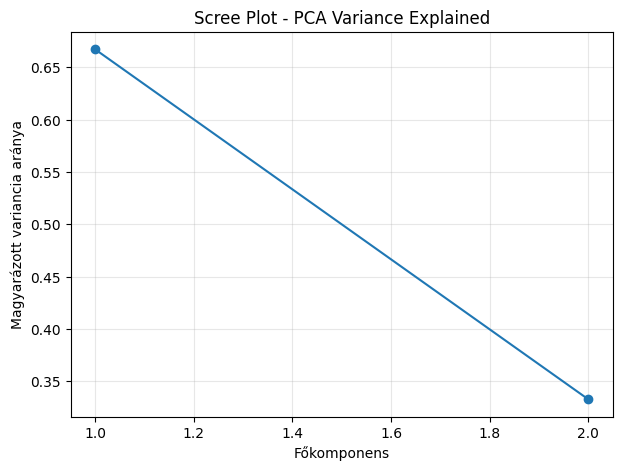

In [25]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(7, 5))
plt.plot([1,2], pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot - PCA Variance Explained')
plt.xlabel('Főkomponens')
plt.ylabel('Magyarázott variancia aránya')
plt.grid(alpha=0.3)
plt.show()

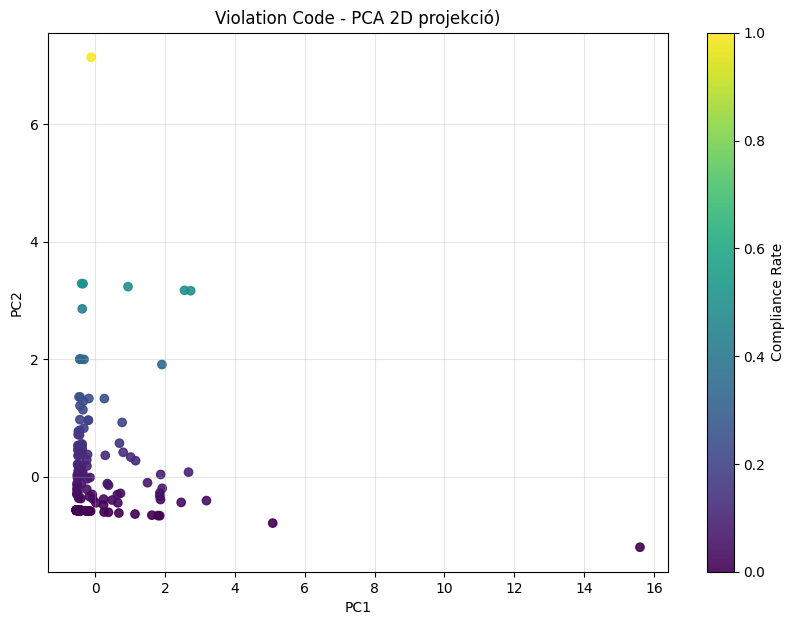

In [26]:
plt.figure(figsize=(10, 7))

plt.scatter(
    pca_features['PC1'],
    pca_features['PC2'],
    c=pca_features["target"],
    cmap='viridis',
    alpha=0.9 
)

plt.title('Violation Code - PCA 2D projekció)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Compliance Rate')
plt.grid(alpha=0.3)
plt.show()

#### 5. rész Összegzés: Vizualizációk

A korelációs mátrix jól mutatta, hogy a pénzbeli oszlopok (fine_amount, judgement_amount stb.)

erősen összefüggenek egymással, ami miatt fontos volt a log-transzformáció használata.

A violation code-ok gyakorisági vizualizációja megmutatta, hogy a bírságok többsége néhány jól ismert

típushoz köthető, de a compliance szempontból ezek nagy szórást mutatnak.

A PCA elemzés feltárta, hogy a sok kategóriából álló violation code mögött kevés, de jól értelmezhető

rejtett dimenzió húzódik meg. A PC1 elsősorban a compliance szinttel függ össze, míg a PC2 inkább a 

bírság súlyosságát reprezentálja.

A PCA alapján a violation code nem ad erős prediktív jelet, de a pénzbeli és viselkedésbeli jellemzőkkel

együtt jól használható.

===============================================================================================================================================================

<div style="page-break-before: always;"></div>

### 6. Modellek építése 

In [27]:
#========================================================================
# Függvény a modell betanításhoz
# Train model on train/test split and return:
#  - probabilities indexed by ticket_id
#  - AUC score
#========================================================================
from sklearn.model_selection import train_test_split 


def train_and_predict(df, model):
    X = df.drop(columns=['target'])
    y = df['target']
    
    # ticket_id külön kezelése visszaadás miatt
    ticket_ids = X['ticket_id'].copy()
    X = X.drop(columns=['ticket_id'])
    
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, ticket_ids,
    test_size=0.2, random_state=42, stratify=y
    )
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    pred_series = pd.Series(y_pred_proba, index=id_test, name='probability')
    
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Model AUC: {auc:.4f}")
    
    return pred_series, auc, y_test
    
    


In [28]:
#========================================================================
# Modell1: Logistic Regression (baseline)
#========================================================================


from sklearn.linear_model import LogisticRegression

model_lr = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=200))
])

pred_lr, auc_lr, y_test_lr = train_and_predict(df, model_lr)
pred_lr.head()

Model AUC: 0.8139


ticket_id
138138    0.035212
149161    0.022452
57262     0.357084
30505     0.061585
192339    0.013783
Name: probability, dtype: float64

In [31]:
#========================================================================
# Modell 2: RandomForest
#========================================================================

from sklearn.ensemble import RandomForestClassifier  

model_rf = Pipeline([
    ("prep", preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=15))
])

pred_rf, auc_rf, y_test_rf = train_and_predict(df, model_rf)
pred_rf.head()


Model AUC: 0.8171


ticket_id
138138    0.046453
149161    0.046118
57262     0.203390
30505     0.066659
192339    0.035467
Name: probability, dtype: float64

In [32]:
#========================================================================
# Modell 3: GradientBoostingClassifier
#========================================================================


from sklearn.ensemble import GradientBoostingClassifier  

model_gb = Pipeline([
    ("prep", preprocess),
    ('clf', GradientBoostingClassifier())
])

pred_gb, auc_gb, y_test_gb = train_and_predict(df, model_gb)
pred_rf.head()


Model AUC: 0.8314


ticket_id
138138    0.046453
149161    0.046118
57262     0.203390
30505     0.066659
192339    0.035467
Name: probability, dtype: float64

#### 6. rész Összefoglaló: Modellek építése

A modelleket egységes train_test_split után értékeltem (20% tesztarány, stratify=y), így

biztosítva, hogy a pozitív/negatív osztály aránya a mintában változatlan maradjon.

Mindhárom modell a teljes preprocessing pipeline-t használja, így összehasonlíthatóak.

A Gradient Boosting bizonyult a legerősebbnek, mivel jól kezeli a kevert típusú jellemzőket

és a nemlináris mintázatokat.

A pred_series visszatérési értéke ticket_id indexeléssel lehetővé teszi a későbbi validációt

és a fordított hozzárendelést.

========================================================================================================================

<div style="page-break-before: always;"></div>

### 7. Értékelés

In [33]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'ROC AUC': [auc_lr, auc_rf, auc_gb]
})

results.style.background_gradient(cmap='Blues').format({'AUC': '{:.4f}'}) 

,Model,ROC AUC
0,Logistic Regression,0.813936
1,Random Forest,0.817129
2,Gradient Boosting,0.831400


In [34]:
import matplotlib.pyplot as plt  

def plot_roc_curve(y_true, y_pred_proba, model_name='Model'):
    fpr, tpr, tresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random baseline')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

Model AUC: 0.8139


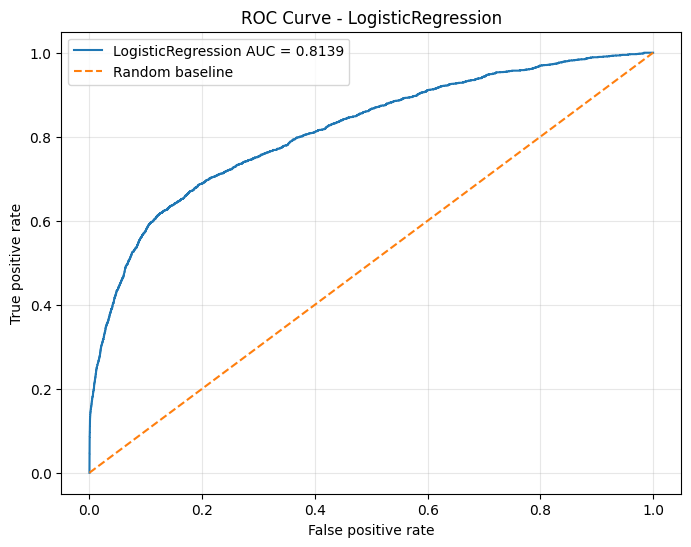

In [35]:
pred_lr, auc_lr, y_test_lr =train_and_predict(df, model_lr)

plot_roc_curve(y_test_lr, pred_lr.values, "LogisticRegression")

#### Classification reports for Logistic Regression:

In [36]:
def print_classification_report(y_test, probas, threshold=0.5):
    y_pred = (probas >= threshold).astype(int)
    print("Classification report for Logistic Regression:\n")
    print(classification_report(y_test, y_pred))

print_classification_report(y_test_lr, pred_lr.values)

Classification report for Logistic Regression:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     29657
         1.0       0.82      0.15      0.26      2319

    accuracy                           0.94     31976
   macro avg       0.88      0.58      0.61     31976
weighted avg       0.93      0.94      0.92     31976



Model AUC: 0.8171


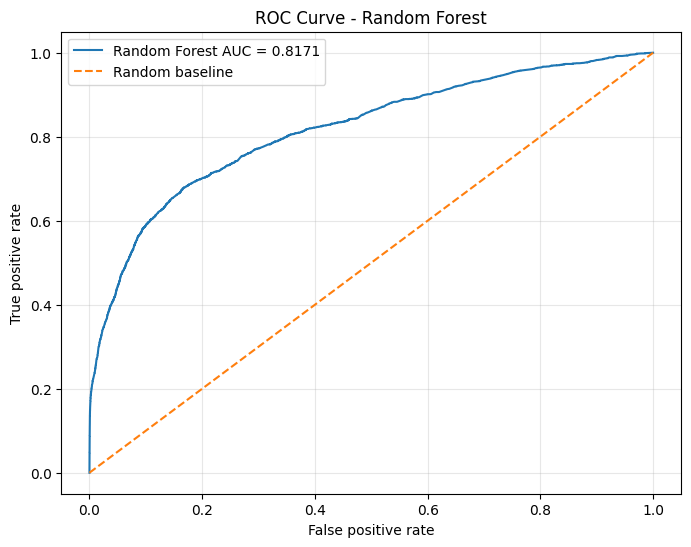

In [37]:
pred_rf, auc_rf, y_test_rf =train_and_predict(df, model_rf)

plot_roc_curve(y_test_rf, pred_rf.values, "Random Forest")


#### Classification reports for Random Forest:

In [38]:
def print_classification_report(y_test, probas, threshold=0.5):
    y_pred = (probas >= threshold).astype(int)
    print("Classification report for Random Forest:\n")
    print(classification_report(y_test, y_pred))
    
print_classification_report(y_test_rf, pred_rf.values)

Classification report for Random Forest:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     29657
         1.0       1.00      0.00      0.01      2319

    accuracy                           0.93     31976
   macro avg       0.96      0.50      0.49     31976
weighted avg       0.93      0.93      0.89     31976



Model AUC: 0.8314


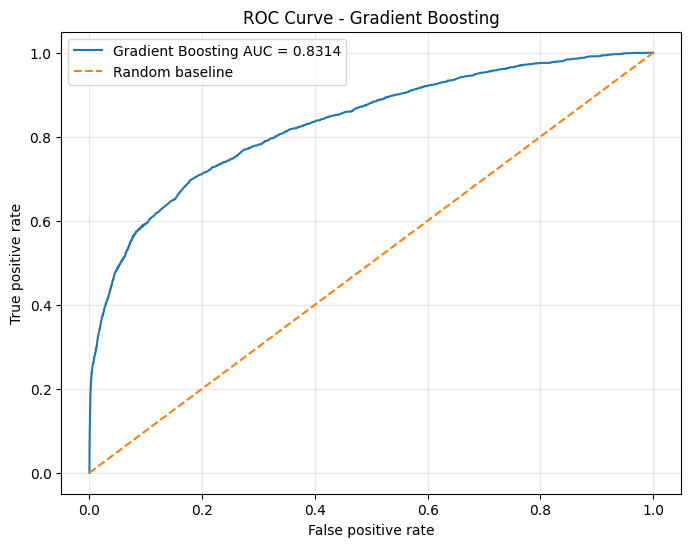

In [39]:
pred_gb, auc_gb, y_test_gb =train_and_predict(df, model_gb)

plot_roc_curve(y_test_gb, pred_gb.values, "Gradient Boosting")

#### Classification reports for Gradient Boosting:

In [40]:
def print_classification_report(y_test, probas, threshold=0.5):
    y_pred = (probas >= threshold).astype(int)
    print("Classification report for Gradient Boosting:\n")
    print(classification_report(y_test, y_pred))
    
print_classification_report(y_test_gb, pred_gb.values)

Classification report for Gradient Boosting:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     29657
         1.0       0.84      0.22      0.35      2319

    accuracy                           0.94     31976
   macro avg       0.89      0.61      0.66     31976
weighted avg       0.94      0.94      0.92     31976



<div style="page-break-before: always;"></div>

### AUC értékelési metrika

A modell teljesítményét a ROC-görbe(Rceiver Operating Characteristic) alatti terület,
vagyis az AUC (Area Under the Curve) segítségével értékeltem.

A ROC-görbe azt mutatja meg, hogyan változik a modell teljesítménye a különböző döntési
küszöbök mellett. A hamis pozitív arány (False Positive Rate)és a valódi pozitív arány
(True Positive Rate) függvényében.

Az AUC értéke 0 és 1 között lehet:
  - 0.5 ~ a modell nem jobb a véletlennél
  - 0.7 - 0.8 = elfogadható teljesítmény
  - 0.8 - 0.9 = jó / erős modell
  - 0.9 felett = kiváló, erősen szeparáló modell

A projekt során elért legjobb modell AUC értéke ~ 0.83, ami azt jelzi, hoy a modell 
megbízhatóan képes elkülöníteni az időben fizető és nem fizető bírságokat.

Az AUC érték értelmezése:

kiválasztunk véletlenszerűen egy olyan ügyet, amelyet időben kifizettek (pozitív osztály),
majd mellé egy másikat, amit nem fizettek ki időben (nagatív osztály), akkor a modell 83% 
valószínűséggel magasabb fizetési valószínűségi pontszámot ad az időben fizetett ügynek.
Azaz az AUC annak a valószínűsége, hogy a modell helyes sorrendbe rendezi egy pozitív és 
egy negatív példa kimenetelét.
Ez közetlenül mutatja, mennyire jól képes a modell megbecsülni a bírságok betartásának esélyét.

A feladat kiírásban előírt minimum AUC érték 0.75 volt. A kapot 0.83-as eredmény ezt egyértelműen meghaladja, így a modell teljesítménye megfelelő, hatékonyan használható a bírságok időbeni
kifizetésének előrejelzésére.

===================================================================================================

### 8. Következtetés

A projekt célja az volt, hogy előre jelezzük, egy adott bírságot időben kifizetnek-e. A teljes

adatelőkészítés, feature engineering és modellezés után, a Gradient Boosting modell 0.83-as AUC

értéket ért el, ami jó megbízhatóságot mutat.

A modell képes felismerni szokat a mintázatokat, amelyek a fizetési hajlandóságot befolyásolják,

például a korábbi bírságok számát, a bírság összegét vagy az időbeli jellemzőket.

A kapott eredmények alapján a modell a gyakorlatban is alkalmazható és segítséget nyújthat, a 

bírságbehajtási folyamat optimalizálásban.